# Creating a Digit Classifier (Almost) from Scratch

In [1]:
from fastai.vision.all import *


/home/krm/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


We're creating a model that can classify any images as a 3 or a 7. We'll use a sample of MNIST that contains just these.

## Data Prep

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
path.ls()

(#3) [Path('/home/krm/.fastai/data/mnist_sample/labels.csv'),Path('/home/krm/.fastai/data/mnist_sample/train'),Path('/home/krm/.fastai/data/mnist_sample/valid')]

The sample data is divided into training and validation sets

In [4]:
(path/"train").ls(), (path/"valid").ls()

((#2) [Path('/home/krm/.fastai/data/mnist_sample/train/7'),Path('/home/krm/.fastai/data/mnist_sample/train/3')],
 (#2) [Path('/home/krm/.fastai/data/mnist_sample/valid/7'),Path('/home/krm/.fastai/data/mnist_sample/valid/3')])

Get a list of the training set of 3s and 7s

In [5]:
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

Have a look at one of the 3s. We use the `Image` class from PIL.

In [6]:
img3_path = threes[2]
img3 = Image.open(img3_path)
img3

We can 'see' the image as a collection of digits using numpy arrays of pytorch tensors. 

In [7]:
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  13,  36],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  89, 253],
       [  0,   0,   0,   0,  17, 151]], dtype=uint8)

In [8]:
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  13,  36],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  89, 253],
        [  0,   0,   0,   0,  17, 151]], dtype=torch.uint8)

Next we create tensors for each of the 3s and 7s.

In [9]:
three_tensors = [tensor(Image.open(path)) for path in threes]
seven_tensors = [tensor(Image.open(path)) for path in sevens]

In [10]:
len(three_tensors), len(seven_tensors)

(6131, 6265)

Use fastai's show_image to see a seven

<AxesSubplot: >

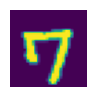

In [11]:
show_image(seven_tensors[6])

We stack each list of tensors into a single one of 3 axes (rank 3), convert to float for some operations. We also scale to values between 0 and 1 (better for the model).

In [12]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

We create a training input collection by concatenating the two stacked tensors into one. We use the `view` method to reshape the tensor into two dimensions. `-1` means making the first dimension as big as possible to accomodate the new shape.

In [13]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

In [14]:
train_x.shape

torch.Size([12396, 784])

In [15]:
train_x[:2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Each item along axis 0 is now a list of 784 floats representing a single image.

We next create labels for our training input. Our objective is to classify whether an image is a 3 or not. The labels for 3s will be 1 (True) and for 7s will be 0 (False).

In [16]:
train_y_flat = tensor([1] * len(threes) + [0] * len(sevens))

In [17]:
train_y_flat.shape

torch.Size([12396])

We need to have a 2D tensor with the second dimension being a size of 1. We use pytorch's `unsqueeze` for that.

In [18]:
train_y = train_y_flat.unsqueeze(1)

In [19]:
train_y.shape

torch.Size([12396, 1])

In pytorch, a dataset needs to return a tuple of (x, y) when indexed. We therefore zip training input and labels.

In [20]:
dataset = list(zip(train_x, train_y))
x0, y0 = dataset[0]
x0.shape, y0.shape

(torch.Size([784]), torch.Size([1]))

We do the same preparation to the validation data as we've done for the training data.

In [21]:
v_threes = (path/"valid"/"3").ls().sorted()
v_sevens = (path/"valid"/"7").ls().sorted()

In [22]:
v_three_tensors = [tensor(Image.open(path)) for path in v_threes]
v_seven_tensors = [tensor(Image.open(path)) for path in v_sevens]

In [23]:
stacked_v_threes = torch.stack(v_three_tensors).float()/255
stacked_v_sevens = torch.stack(v_seven_tensors).float()/255

In [24]:
valid_x = torch.cat([stacked_v_threes, stacked_v_sevens]).view(-1, 28 * 28)
valid_x.shape

torch.Size([2038, 784])

In [25]:
valid_y = tensor([1] * len(v_threes) + [0] * len(v_sevens)).unsqueeze(1)
valid_y.shape

torch.Size([2038, 1])

In [26]:
validation_dataset = list(zip(valid_x, valid_y))

## Training

The initial model will be a linear function with weights for each pixel and a bias. We'll need to calculate gradients for each of these, so we call `requires_grad`.

In [27]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [28]:
weights = init_params((28*28, 1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [29]:
def linear(x_batch): return x_batch@weights + bias

Next, we need to define a loss function that is sensitive to small changes in the parameters. For each batch of predictions, we calculate distance from the target values, and get the mean.

We also need to coerce the predictions to values between 0 and 1, so we'll use a sigmoid function for this.

In [30]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [31]:
def mnist_loss(predictions, targets):
    predictions = sigmoid(predictions)
    return torch.where(targets==1, 1-predictions, predictions).mean()

We now have enough to calculate gradients. We define a procedure that makes predictions, calculates the loss, then calculates the gradients that would minimise the loss

In [32]:
def calculate_gradients(x_batch, y_batch, model):
    predictions = model(x_batch)
    loss = mnist_loss(predictions, y_batch)
    loss.backward()

We need to iteratively process mini batches until we exhaust the entire dataset. The `fastai` library provides a `DataLoader` class that will shuffle the dataset and provide batches of input and their corresponding targets according to the batch size we provide. We can iterate through this to process the entire dataset.

In [33]:
train_dl = DataLoader(dataset, batch_size=256)
valid_dl = DataLoader(validation_dataset, batch_size=256)

Now we can encode the process of training through an entire epoch. With each mini-batch, we optimize the parameters using the gradients and learning rate. We're adjusting each parameter in opposite direction of the gradient to get closer to a minimized loss.

In [34]:
def train_epoch(model, learning_rate, params):
    for x, y in train_dl:
        calculate_gradients(x, y, model)
        for p in params:
            p.data -= p.grad * learning_rate
            p.grad.zero_()  # reset gradient

We'll also calculate an accuracy metric for each epoch so that we can observe that the accuracy is improving with each successive epoch.

We first calculate the metric for each batch:

In [35]:
def batch_accuracy(predictions, targets):
    predictions = sigmoid(predictions)
    correct = (predictions > 0.5) == targets
    return correct.float().mean()

Then average it for the entire epoch (rounded off to 4 decimal places):

In [36]:
def validate_epoch(model):
    accuracies = [batch_accuracy(model(x_batch), y_batch) for x_batch, y_batch in valid_dl]
    return round(torch.stack(accuracies).mean().item(), 4)

We can now see the model performance for the entire epoch. We define a procedure that takes in the model, parameters, learning rate and number of epochs and prints out the accuracy.

In [37]:
def learn(model, params, learning_rate, epochs):
    for i in range(epochs):
        train_epoch(model, learning_rate, params)
        print(validate_epoch(model))

In [38]:
learn(linear, params=(weights, bias), learning_rate=1.0, epochs=20)

0.662
0.8637
0.9233
0.9399
0.9487
0.9546
0.9604
0.9638
0.9658
0.9673
0.9678
0.9682
0.9697
0.9707
0.9721
0.9736
0.9736
0.9736
0.9741
0.9741


We see that the accuracy gradually improves to approx 96%. 


Pytorch provides some handy functionality that we can use to simplify the process above.
`nn.Linear` will combine what `init_params` and `linear` do together.

In [45]:
linear_model = nn.Linear(28 * 28, 1)
weights, bias = linear_model.parameters()
weights.shape, bias.shape

(torch.Size([1, 784]), torch.Size([1]))

We can also create an optimizer class that will optimize parameters using an interface that can plug into pytorch functionality.

In [46]:
class BasicOptimizer:
    def __init__(self, params, learning_rate):
        self.params = params
        self.learning_rate = learning_rate
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.learning_rate
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [47]:
optimizer = BasicOptimizer(linear_model.parameters(), 1.0)

We can re-write `train_epoch` and `learn` to use the new optimizer.

In [48]:
def train_epoch(model):
    for x, y in train_dl:
        calculate_gradients(x, y, model)
        optimizer.step()
        optimizer.zero_grad()
        
def learn(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model))

We should get similar results to the previous run

In [49]:
learn(linear_model, epochs=20)

0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932
0.4932


In [50]:
weights

Parameter containing:
tensor([[ 3.4429e-02,  1.7063e-03, -3.5834e-03,  3.0296e-03, -8.0531e-03,
         -1.7961e-02, -3.0332e-02, -1.6867e-02,  3.5372e-02,  1.9368e-02,
         -1.6617e-02, -1.5027e-02, -1.1246e-02,  9.8497e-03,  1.4193e-02,
          1.6653e-02, -3.4344e-02,  2.2654e-02,  1.2755e-02,  3.3253e-03,
          3.4526e-02,  2.2616e-02,  3.2427e-02, -1.9899e-02, -1.1922e-02,
          3.2503e-02, -1.0366e-02,  3.1291e-02,  8.3053e-03,  1.8344e-02,
          1.7709e-02,  2.8762e-02, -5.9348e-03, -1.4912e-02,  2.7102e-02,
         -1.3664e-02, -9.9282e-03, -1.3380e-02, -1.5455e-02,  1.7812e-02,
          2.0769e-02, -2.6720e-02,  1.9830e-02,  1.3241e-02,  1.6200e-02,
         -2.3283e-02,  1.5969e-02, -9.3796e-03, -1.9109e-02, -8.8091e-03,
         -3.3644e-03,  2.0112e-03, -1.3490e-03, -1.2946e-02, -1.4998e-02,
         -1.3929e-02,  3.0322e-02,  3.3482e-02, -1.5245e-02,  1.7808e-02,
         -1.3369e-02, -3.5230e-03, -2.6577e-02,  5.2185e-03, -2.1949e-02,
          1.7526